In [1]:
#Import necessary packages

import pandas as pd
from sklearn.cluster import KMeans
import requests
import pylab as pl

In [2]:
api_key='###############################' #this can be taken from financialmodelingapi
tickers=['CAT','BUD','CSCO','LEVI','ADM','DELL','TWNK','SKX','WDC','IBM','KO']
#empty lists and colorcode for Beanish-M and Altman-Z
z_score = [] #the number
z_result=[] #the color
m_score = []
m_result=[]
coloring = ['red','grey','green']

In [4]:
#Setting up commands that will be used later

def show_company_profile(ticker): 
    term='profile'
    quote=requests.get(f'https://financialmodelingprep.com/api/v3/{term}/{ticker}?apikey={api_key}').json()
    return quote

def show_balance_sheet(ticker):
    term='balance-sheet-statement'
    balance_sheet=requests.get(f'https://financialmodelingprep.com/api/v3/{term}/{ticker}?apikey={api_key}').json()
    return balance_sheet

def show_income_statements(ticker):
    term='income-statement'
    income_statements=requests.get(f'https://financialmodelingprep.com/api/v3/{term}/{ticker}?apikey={api_key}').json()  
    return income_statements

def show_cash_flow_statements(ticker):
    term='cash-flow-statement'
    cash_flow_s=requests.get(f'https://financialmodelingprep.com/api/v3/{term}/{ticker}?apikey={api_key}').json()
    return cash_flow_s

#The below gets the data from above functions and then takes necessary values for Z and M scores

def get_data(ticker):
    #get the data that we need for both indicators
    bs, ins, cfs, prof = show_balance_sheet(ticker), show_income_statements(ticker), show_cash_flow_statements(ticker), show_company_profile(ticker)
    #get the necessary data
    receivables, receivables_1=float(bs[0]['netReceivables']), float(bs[1]['netReceivables'])
    sales, sales_1 = float(ins[0]['revenue']), float(ins[1]['revenue'])
    cogs, cogs_1 = float(ins[0]['costOfRevenue']), float(ins[1]['costOfRevenue'])
    ta, ta_1 = float(bs[0]['totalAssets']), float(bs[1]['totalAssets'])
    c_a, c_a_1 = float(bs[0]['totalCurrentAssets']), float(bs[1]['totalCurrentAssets'])
    c_l, c_l_1 = float(bs[0]['totalCurrentLiabilities']), float(bs[1]['totalCurrentLiabilities'])
    wc = c_a - c_l
    ppe, ppe_1 = float(bs[0]['propertyPlantEquipmentNet']), float(bs[1]['propertyPlantEquipmentNet'])
    dep, dep_1 = float(ins[0]['depreciationAndAmortization']), float(ins[1]['depreciationAndAmortization'])
    sga, sga_1 = float(ins[0]['generalAndAdministrativeExpenses']), float(ins[1]['generalAndAdministrativeExpenses'])
    lt_d, lt_d_1 = float(bs[0]['longTermDebt']), float(bs[1]['longTermDebt'])
    re=float(bs[0]['retainedEarnings'])
    ni = float(ins[0]['netIncome'])
    co=float(cfs[0]['netCashProvidedByOperatingActivities'])
    mc = float(prof[0]['mktCap'])
    ebit=float(ins[0]['incomeBeforeTax'])
    t_l=float(bs[0]['totalLiabilities'])
    tab = {'receivables': [receivables, receivables_1],
           'sales': [sales, sales_1],
           'cogs': [cogs, cogs_1],
           'total assets': [ta, ta_1],
           'current assets':[c_a,c_a_1],
           'current liabilities':[c_l,c_l_1],
           'ppe':[ppe, ppe_1],
           'depreciation': [dep, dep_1],
           'sales g and a': [sga, sga_1],
           'long-term debt': [lt_d, lt_d_1],
           'net income':[ni],
           'cash from op': [co],
           'working cap':[wc],
           'retained earnings':[re],
           'market cap':[mc],
           'ebit':[ebit],
           'total liabs':[t_l]}
    return tab

In [5]:
#Now two functions for Beanish M and Altman Z
#Formulas are taken from https://en.wikipedia.org/wiki/Beneish_M-score and https://en.wikipedia.org/wiki/Altman_Z-score
def bm(ticker):
    data = get_data(ticker)
    #INDECIES
    dsri = (data['receivables'][0]/data['sales'][0])/(data['receivables'][1]/data['sales'][1])
    gmi = ((data['sales'][1] - data['cogs'][1])/data['sales'][1])/((data['sales'][0] - data['cogs'][0])/data['sales'][0])
    aqi = ((data['total assets'][0] - data['current assets'][0] - data['ppe'][0])/data['total assets'][0])/((data['total assets'][1] - data['current assets'][1] - data['ppe'][1])/data['total assets'][1])
    sgi = data['sales'][0]/data['sales'][1]
    depi = (data['depreciation'][1] / (data['ppe'][1]+data['depreciation'][1]))/(data['depreciation'][0] / (data['ppe'][0]+data['depreciation'][0]))
    sgai = (data['sales g and a'][0]/data['sales'][0])/(data['sales g and a'][1]/data['sales'][1])
    lvgi = ((data['current liabilities'][0]+data['long-term debt'][0])/data['total assets'][0])/((data['current liabilities'][1]+data['long-term debt'][1])/data['total assets'][1])
    tata = (data['net income'][0]-data['cash from op'][0])/data['total assets'][0]
    m_score = -4.84+0.92*dsri+0.528*gmi+0.404*aqi+0.8992*sgi+0.115*depi-0.172*sgai+4.679*tata-0.327*lvgi
    return m_score

def zs(ticker):
    data = get_data(ticker)
    X1=data['working cap'][0]/data['total assets'][0]
    X2=data['retained earnings'][0]/data['total assets'][0]
    X3=data['ebit'][0]/data['total assets'][0]
    X4=data['market cap'][0]/data['total liabs'][0]
    X5=data['sales'][0]/data['total assets'][0]
    z_score=1.2*X1+1.4*X2+3.3*X3+0.6*X4+1.0*X5
    return z_score


In [6]:
# for loop to label tickers based on cut-off
for ticker in tickers:
    print('calculating for ',ticker)
    m_score.append(bm(ticker))
    z_score.append(zs(ticker))

#the filtering loop
for i in range(len(tickers)):
    if m_score[i] <= -2: 
       m_result.append(coloring[2])
    if -2.00 < m_score[i] < -1.78:
        m_result.append(coloring[1])
    if m_score[i] >= - 1.78:
        m_result.append(coloring[0])
    if z_score[i] >=2.99:
        z_result.append(coloring[2])
    if 1.89 < z_score[i] < 2.99:
        z_result.append(coloring[1])
    if z_score[i] <1.89:
        z_result.append(coloring[0])
    print('done!')


calculating for  CAT
calculating for  BUD
calculating for  CSCO
calculating for  LEVI
calculating for  ADM
calculating for  DELL
calculating for  TWNK
calculating for  SKX
calculating for  WDC
calculating for  IBM
calculating for  KO
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!


In [7]:
#Create a df with z_results and m_results
df = pd.DataFrame({'m_score':m_score,
                   'z_score':z_score,
                   'manipulator':m_result,
                   'bankrupt':z_result}, index=tickers)
#lets first see what we have for observations
df

,m_score,z_score,manipulator,bankrupt
CAT,-2.669678,2.795323,green,grey
BUD,-2.831657,1.002873,green,red
CSCO,-2.585234,3.530072,green,green
LEVI,-2.994552,2.879441,green,grey
ADM,-2.266854,2.954726,green,grey
DELL,-2.560121,1.140338,green,red
TWNK,-2.490426,1.315397,green,red
SKX,-2.716613,3.275408,green,green
WDC,-1.758055,1.995437,red,grey
IBM,-3.083732,2.593603,green,grey


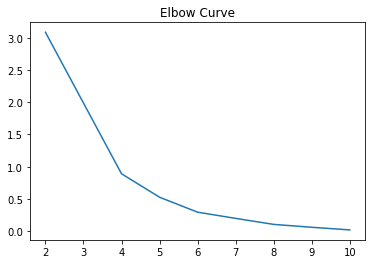

In [8]:
#split the data to clusters
X = df[['m_score','z_score']].values
SSE = []
observe = range(2,len(tickers))
for k in observe:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)
#pick the best number of clusters using the elbow curve    
pl.plot(observe, SSE)
pl.title('Elbow Curve')
pl.show()

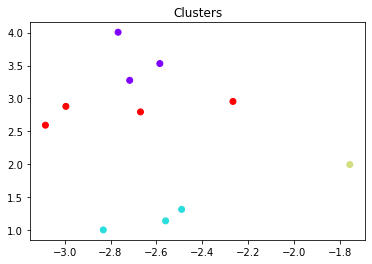

In [9]:
#By EC, the best fit occurs at 4 clusters, so
n_best = 4
#run again with n_clusters = n_best
kmeans = KMeans(n_clusters = n_best).fit(X)

pl.show()
cluster_labels = list(kmeans.labels_)
df['cluster'] = cluster_labels
#plot clusters

pl.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
pl.title('Clusters')
pl.show()

In [10]:
df

,m_score,z_score,manipulator,bankrupt,cluster
CAT,-2.669678,2.795323,green,grey,3
BUD,-2.831657,1.002873,green,red,1
CSCO,-2.585234,3.530072,green,green,0
LEVI,-2.994552,2.879441,green,grey,3
ADM,-2.266854,2.954726,green,grey,3
DELL,-2.560121,1.140338,green,red,1
TWNK,-2.490426,1.315397,green,red,1
SKX,-2.716613,3.275408,green,green,0
WDC,-1.758055,1.995437,red,grey,2
IBM,-3.083732,2.593603,green,grey,3
